In [1]:
# Imports
import os
from os.path import abspath
import sys
import torch
import copy
import pickle
from pathlib import Path
import tqdm
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_auc_score

In [2]:
# Set working directory
os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'/home/ubuntu/master_thesis'

In [3]:
# Import local libraries
from src.logger import set_logger as sl

# Load transformations
from src.transformations.CC_RRC_RVF_RHF_RA import get_transform as gt_train
from src.transformations.CC_R import get_transform as gt_valid
from src.plot_images import plot_images
from src.train_validation import train_validation_phase

In [4]:
# Set-up logger
try:
    if logger is None:
        logger = sl("info")
except:
    logger = sl("info")

# Parameters

In [5]:
# Put data
epochs        = 100

learning_rate = 0.01
momentum      = 0.9

batch_size    = 64
num_workers   = os.cpu_count()
is_pretrained = False

crop_size     = 1336
im_size       = (300, 300)
is_grayscale  = False

train_pth     = abspath('./data/raw/train/')
valid_pth     = abspath('./data/raw/validation/')

name = f"ukbb-crop-raw-4da-cs{crop_size}-ims{im_size[0]}x{im_size[1]}_iv3-e{epochs}-bs{batch_size}-lrv{str(learning_rate)[2:]}-m{str(momentum)[2:]}"

model_pth     = abspath(f'./output/models/{name}.pth')

device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
######################################################################################
# Initial report
logger.info(f"System Python version  = {sys.version}")
logger.info(f"System Pytorch version = {torch.__version__}")
logger.info(f"System usable CPUs     = {os.cpu_count()}")

# Device setting and CUDA report 
logger.info(f"System training device = {device}")
if  torch.cuda.is_available():
    logger.info(f"System CUDA version    = {torch.version.cuda}")
    logger.info(f"System CUDA count      = {torch.cuda.device_count()}")
    logger.info(f"System CUDA name       = {torch.cuda.get_device_name()}")
    
# Load train and validation dataset
logger.info(f"Path working directory = {os.getcwd()}")
logger.info(f"Path input train       = {train_pth}")
logger.info(f"Path input validation  = {valid_pth}")
logger.info(f"Path model             = {model_pth}")

# Starting momentum and learning rate
logger.info(f"Model learning rate    = {learning_rate}")
logger.info(f"Model momentum         = {momentum}")
logger.info(f"Model batch_size       = {batch_size}")
logger.info(f"Model num_workers      = {num_workers}")
logger.info(f"Model pretrained       = {is_pretrained}")

2020-11-20 21:11:31,465 - INFO - System Python version  = 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
2020-11-20 21:11:31,466 - INFO - System Pytorch version = 1.6.0
2020-11-20 21:11:31,467 - INFO - System usable CPUs     = 96
2020-11-20 21:11:31,468 - INFO - System training device = cuda:0
2020-11-20 21:11:31,468 - INFO - System CUDA version    = 10.2
2020-11-20 21:11:31,469 - INFO - System CUDA count      = 8
2020-11-20 21:11:31,481 - INFO - System CUDA name       = Tesla T4
2020-11-20 21:11:31,482 - INFO - Path working directory = /home/ubuntu/master_thesis
2020-11-20 21:11:31,483 - INFO - Path input train       = /home/ubuntu/master_thesis/data/raw/train
2020-11-20 21:11:31,483 - INFO - Path input validation  = /home/ubuntu/master_thesis/data/raw/validation
2020-11-20 21:11:31,484 - INFO - Path model             = /home/ubuntu/master_thesis/output/models/ukbb-crop-raw-4da-cs1336-ims300x300_iv3-e100-bs64-lrv01-m9.pth
2020-11-20 21:11:31,484 - INFO - Model learning rate    = 

# Dataset

2020-11-20 21:11:31,497 - INFO - Loading datasets
2020-11-20 21:11:35,760 - INFO - Dataset size training   = 140000
2020-11-20 21:11:35,763 - INFO - Dataset size validation = 17492
2020-11-20 21:11:35,763 - INFO - Dataset labels/classes  = ['female', 'male']
2020-11-20 21:11:35,764 - INFO - Loading dataloaders
2020-11-20 21:11:35,765 - INFO - Plot sample images
female  male female female female female  male female


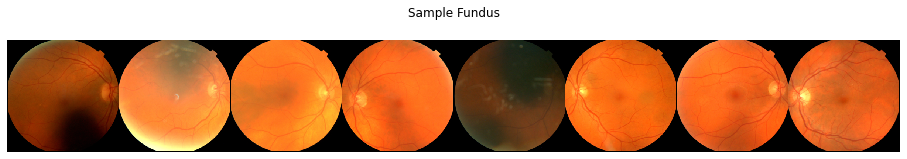

In [7]:
######################################################################################
# Load datasets and apply transformations
logger.info(f"Loading datasets")
dataset = dict()
dataset["train"] = datasets.ImageFolder(train_pth, gt_train(crop_size, resize=im_size, grayscale=is_grayscale))
dataset["valid"] = datasets.ImageFolder(valid_pth, gt_valid(crop_size, resize=im_size, grayscale=is_grayscale))

# Get the size of the datasets train and valid(ation)
size = dict()
size["train"] = len(dataset["train"])
size["valid"] = len(dataset["valid"])
logger.info(f"Dataset size training   = {size['train']}")
logger.info(f"Dataset size validation = {size['valid']}")
logger.info(f"Dataset labels/classes  = {dataset['train'].classes}")

# Dataloader for train and valid(ation)
logger.info(f"Loading dataloaders")
dataloader = dict()
dataloader["train"] = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
dataloader["valid"] = DataLoader(dataset["valid"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

######################################################################################
# Get sample images
logger.info(f"Plot sample images")
plot_images(dataloader["valid"],  dataset["valid"].classes, title="Sample Fundus", save=name)

# Model

In [ ]:
# Load model
model = models.inception_v3(pretrained=is_pretrained,
                            init_weights=True,
                            aux_logits=False)

logger.info(f"Model loading            = {model.__class__.__name__}")

# Get number of features in the model
n_ftrs = model.fc.in_features
logger.info(f"Model number of features = {n_ftrs}")

# Add linear transformation to the data
model.fc = nn.Linear(n_ftrs, len(dataset["train"].classes))

######################################################################################
# Send model to device, 
# if CUDA count is greater than 1 use multiple GPUs
model = model.to(device)
usable_devices =list(range(torch.cuda.device_count()))
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=usable_devices, output_device=device)
    logger.info(f"Let's use {torch.cuda.device_count()} GPUs!")

######################################################################################
# Get Optimization and crossentropy
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

######################################################################################
results = train_validation_phase(model=model,
                               dataset=dataset,
                               dataloader = dataloader,
                               device=device,
                               epochs=epochs,
                               criterion=criterion,
                               optimizer=optimizer,
                               save = model_pth,
                               logger=logger)

2020-11-20 21:13:05,585 - INFO - Model loading            = Inception3
2020-11-20 21:13:05,587 - INFO - Model number of features = 2048
2020-11-20 21:13:05,651 - INFO - Let's use 8 GPUs!
2020-11-20 21:14:17,293 - INFO - Epoch [  1/100] - Batch [     0/140000] ( 0%) - Loss 0.7027
2020-11-20 21:15:16,203 - INFO - Epoch [  1/100] - Batch [  6400/140000] ( 5%) - Loss 0.7557
2020-11-20 21:16:12,978 - INFO - Epoch [  1/100] - Batch [ 12800/140000] ( 9%) - Loss 0.8613
2020-11-20 21:17:09,830 - INFO - Epoch [  1/100] - Batch [ 19200/140000] (14%) - Loss 1.0530
2020-11-20 21:18:05,422 - INFO - Epoch [  1/100] - Batch [ 25600/140000] (18%) - Loss 0.9768
2020-11-20 21:19:00,866 - INFO - Epoch [  1/100] - Batch [ 32000/140000] (23%) - Loss 0.6891
2020-11-20 21:19:55,951 - INFO - Epoch [  1/100] - Batch [ 38400/140000] (27%) - Loss 0.7413
2020-11-20 21:20:51,121 - INFO - Epoch [  1/100] - Batch [ 44800/140000] (32%) - Loss 0.7214
2020-11-20 21:21:46,311 - INFO - Epoch [  1/100] - Batch [ 51200/1400

In [ ]:
# Save the results to a pickle file
with open(f"output/{name}_results_copy.pkl", "wb") as RESULTS:
    pickle.dump(results, RESULTS, protocol=pickle.HIGHEST_PROTOCOL)